In [ ]:
from google.colab import drivel
drive.mount('/content/drive')


Mounted at /content/drive


### Training the model

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
import os

# Function to count the number of classes in the dataset folder
def count_classes(data_dir):
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    return len(classes)

data_dir = '/content/drive/MyDrive/MTP/Dataset/Images'

# Load pre-trained EfficientNet-B0 model
efficientnet = EfficientNet.from_pretrained('efficientnet-b0')

# Count the number of classes in the dataset folder
num_classes = count_classes(data_dir)

# Modify the last fully connected layer for the detected number of classes
num_ftrs = efficientnet._fc.in_features
efficientnet._fc = nn.Linear(num_ftrs, num_classes)

# Define data transformations and create a DataLoader
data_transforms = transforms.Compose([
    transforms.Resize(224),  # EfficientNet-B0 requires input size of 224x224
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load only the first 20 images from each class folder
custom_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)
first_20_dataset = torch.utils.data.Subset(custom_dataset, [idx for idx in range(1000 * num_classes)])

# Create DataLoader for the modified dataset
custom_dataloader = torch.utils.data.DataLoader(first_20_dataset, batch_size=32, shuffle=True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet.parameters(), lr=0.001)  # Optimize all parameters

# Training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
efficientnet = efficientnet.to(device)

num_epochs = 5
for epoch in range(num_epochs):
    efficientnet.train()
    running_loss = 0.0

    for inputs, labels in custom_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = efficientnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(first_20_dataset)
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}')


Loaded pretrained weights for efficientnet-b0


In [ ]:
# Save the trained model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': efficientnet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': epoch_loss,
}, '/content/model_efficientnet.pth')


### Load the saved model

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

# Printing the number of classes
count_classes(data_dir)

# Load the trained model checkpoint
checkpoint = torch.load('/content/model_efficientnet.pth')

# Load EfficientNet-B0 model architecture
loaded_efficientnet = EfficientNet.from_name('efficientnet-b0')

# Modify the last fully connected layer for two classes if needed
num_ftrs = loaded_efficientnet._fc.in_features
loaded_efficientnet._fc = nn.Linear(num_ftrs, count_classes(data_dir))

# Load the trained model's state dict
loaded_efficientnet.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
loaded_efficientnet.eval()

# Access other information if needed
epoch = checkpoint['epoch']
loss = checkpoint['loss']


###Import DIP library

In [ ]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
!git clone https://github.com/DmitryUlyanov/deep-image-prior
!mv deep-image-prior/* ./


Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 24.28 MiB | 31.08 MiB/s, done.
Resolving deltas: 100% (155/155), done.


###Set up environment

In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from efficientnet_pytorch import EfficientNet
import torch
from models.skip import skip
import torch.optim

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64


###Image, Mask Selection and Visualisation

In [ ]:
## Fig
img_path = '/content/input_image.png'
mask_path = '/content/drive/MyDrive/mask.png'

NET_TYPE = 'EfficientNet'  # Change from 'ResNet' to 'EfficientNet'




In [ ]:
img_pil, img_np = get_image(img_path, 512)
img_pil = img_pil.convert("RGB")
img_np = np.array(img_pil)

img_mask_pil, img_mask_np = get_image(mask_path, 512)
img_mask_pil = img_mask_pil.convert("RGB")
img_mask_np = np.array(img_mask_pil)


In [ ]:
img_np.shape

(512, 512, 3)

In [ ]:
img_mask_pil = crop_image(img_mask_pil, dim_div_by)
img_pil = crop_image(img_pil, dim_div_by)

img_np = pil_to_np(img_pil)
img_mask_np = pil_to_np(img_mask_pil)


In [ ]:
print(img_mask_np.shape)
img_np.shape

(3, 512, 512)


(3, 512, 512)

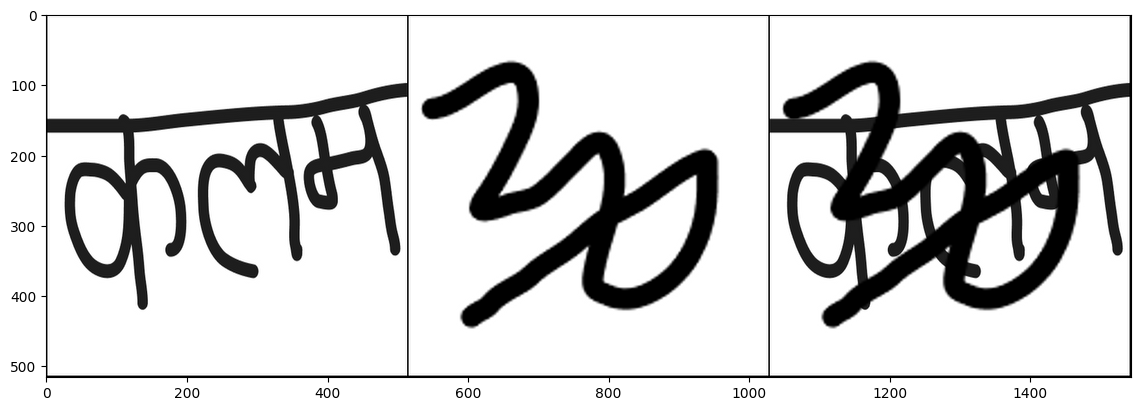

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 1., 0., 0.],
        ...,
        [0., 0., 1., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 1., 0., 0.],
        ...,
        [0., 0., 1., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 1., 0., 0.],
        ...,
        [0., 0., 1., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [ ]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3, 11)

In [ ]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'
#Adam optimizer is an optimization algorithm that extends SGD by dynamically adjusting learning rates based on individual weights

###Main Loop

In [ ]:
INPUT = 'noise'
input_depth = 32
LR = 0.01
num_iter = 5000
param_noise = False
show_every = 50
figsize = 5
reg_noise_std = 0.03

net = skip(input_depth, img_np.shape[0],
               num_channels_down = [128] * 5,
               num_channels_up =   [128] * 5,
               num_channels_skip =    [128] * 5,
               filter_size_up = 3, filter_size_down = 3,
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [ ]:
net_input

tensor([[[[0.0956, 0.0497, 0.0961,  ..., 0.0944, 0.0941, 0.0460],
          [0.0781, 0.0678, 0.0790,  ..., 0.0583, 0.0233, 0.0240],
          [0.0948, 0.0364, 0.0312,  ..., 0.0705, 0.0202, 0.0821],
          ...,
          [0.0834, 0.0739, 0.0215,  ..., 0.0041, 0.0545, 0.0793],
          [0.0333, 0.0109, 0.0208,  ..., 0.0711, 0.0530, 0.0355],
          [0.0060, 0.0535, 0.0420,  ..., 0.0182, 0.0836, 0.0007]],

         [[0.0397, 0.0822, 0.0620,  ..., 0.0241, 0.0775, 0.0103],
          [0.0090, 0.0420, 0.0979,  ..., 0.0808, 0.0633, 0.0357],
          [0.0641, 0.0835, 0.0667,  ..., 0.0857, 0.0770, 0.0126],
          ...,
          [0.0352, 0.0311, 0.0043,  ..., 0.0825, 0.0711, 0.0263],
          [0.0705, 0.0213, 0.0098,  ..., 0.0753, 0.0885, 0.0693],
          [0.0241, 0.0852, 0.0687,  ..., 0.0130, 0.0954, 0.0762]],

         [[0.0930, 0.0352, 0.0348,  ..., 0.0418, 0.0395, 0.0949],
          [0.0095, 0.0381, 0.0837,  ..., 0.0022, 0.0975, 0.0157],
          [0.0321, 0.0394, 0.0171,  ..., 0

In [ ]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 3002627


Starting optimization with ADAM


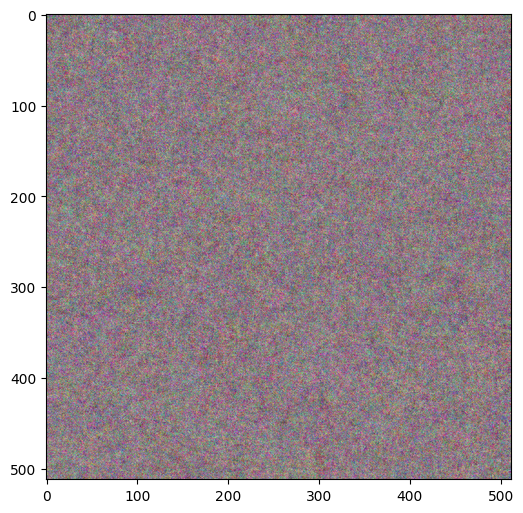

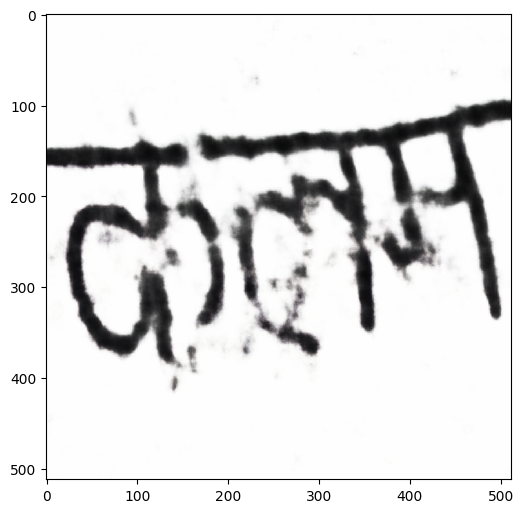

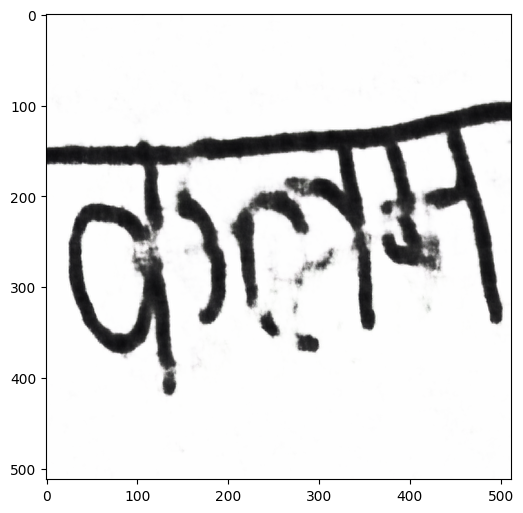

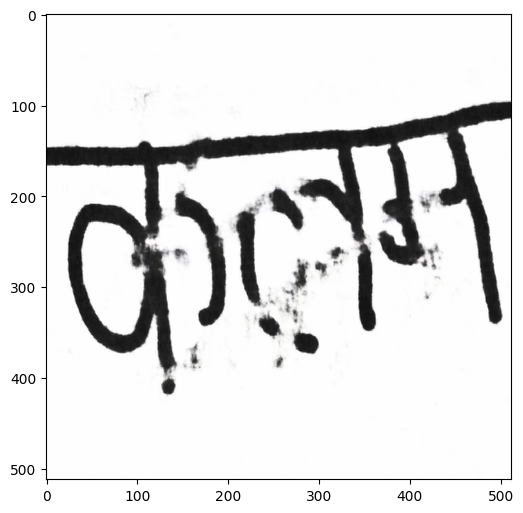

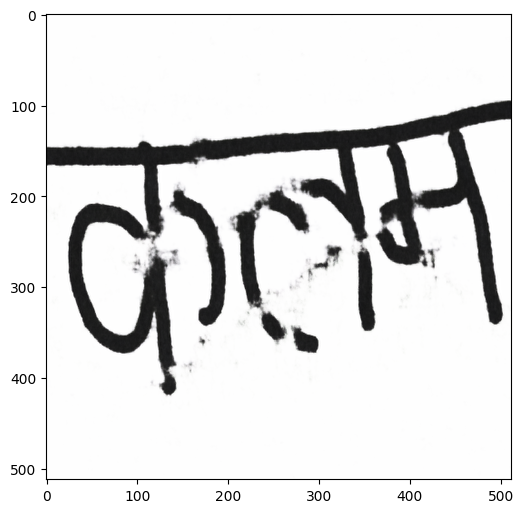

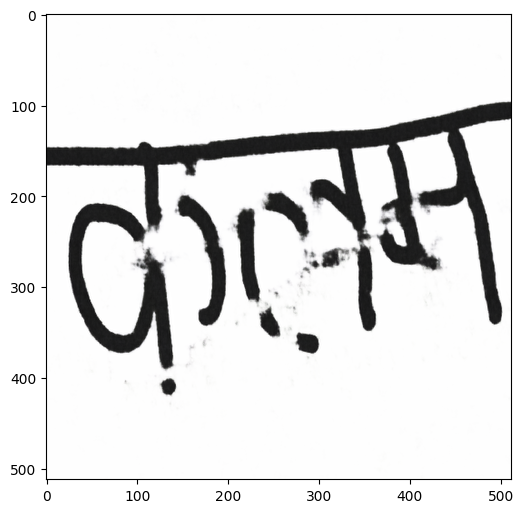

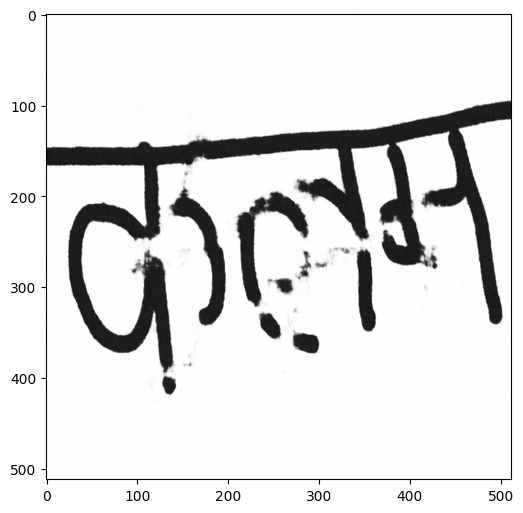

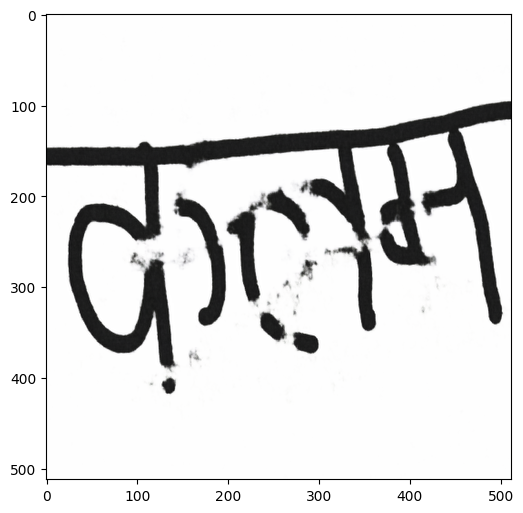

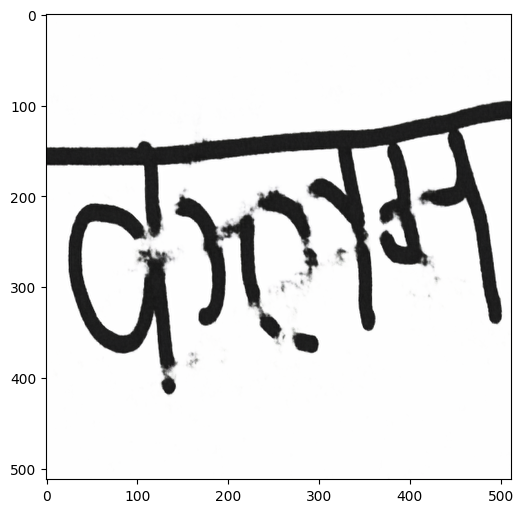

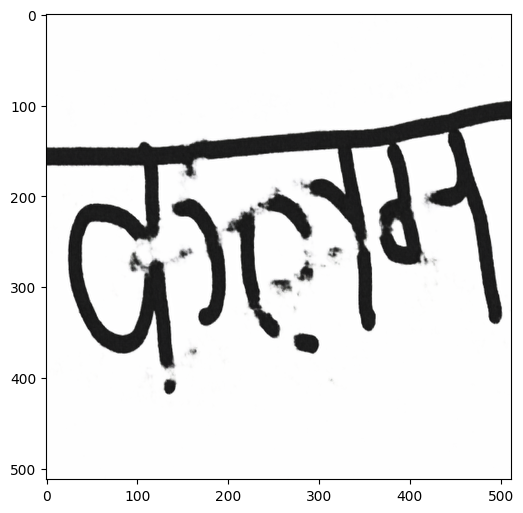

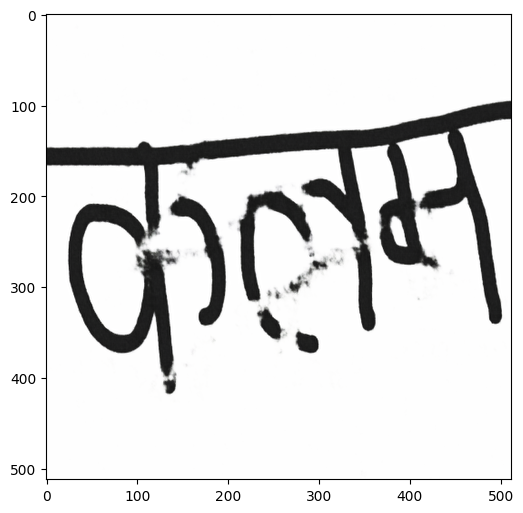

In [ ]:
i = 0
loss = []
def closure():

    global i

    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50

    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)


    out = net(net_input)
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
    loss.append((i, total_loss.item()))
    # print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        print ('SHOW Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
        # loss.append((i, total_loss.item()))
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

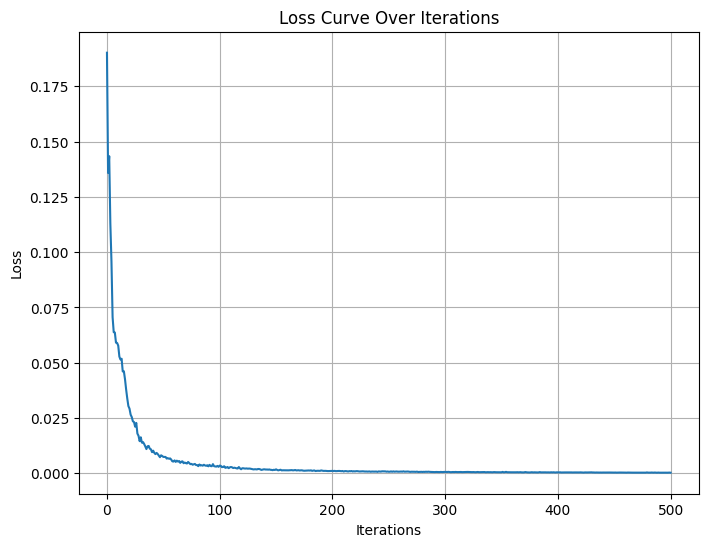

In [ ]:
import matplotlib.pyplot as plt

# Assuming loss is your array of tuples (i, curr_loss)
iterations = [item[0] for item in loss]  # Extracting iteration values
loss_values = [item[1] for item in loss]  # Extracting loss values

# Plotting the curve
plt.figure(figsize=(8, 6))
plt.plot(iterations, loss_values, linestyle='-')
plt.title('Loss Curve Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


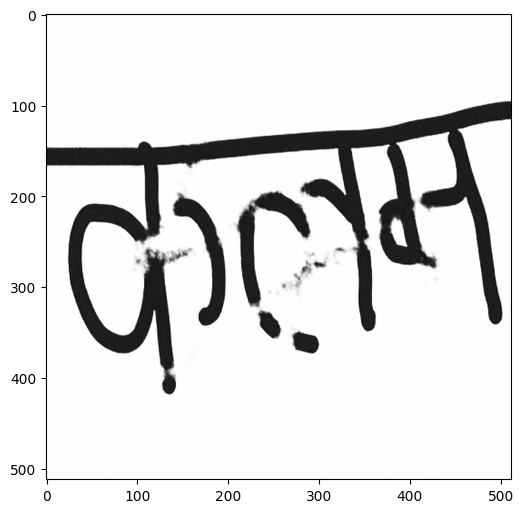

In [ ]:
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);